# Demand Forecasting

## Problem Statement:

Use machine learning to forecast demand for car based on the historic sales data. The dataset contains historic data from Jan 2007 to Jan 2017.

## Overview:

1. Data preparation and KPIs
2. Maximum likelihood estimator
3. Decision Trees
4. Random Forest
5. Extreme Gradient Boosting / XGBoost
6. Feature Optimization

## 1. Data preparation and KPIs

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

path = "/content/drive/MyDrive/Demand_Forecasting_Project/norway_car_sales/norway_new_car_sales_by_make.csv"

In [2]:
data = pd.read_csv(path)
data.head()

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4377 entries, 0 to 4376
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      4377 non-null   int64  
 1   Month     4377 non-null   int64  
 2   Make      4367 non-null   object 
 3   Quantity  4377 non-null   int64  
 4   Pct       4377 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 171.1+ KB


There are 10 null entries in the 'Make' column. We will drop these rows as we are trying to forecast demand for the product, and the product name is missing.

In [4]:
# Coverting to time series and drop null values

data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
data.dropna(inplace=True)
print(data.shape)

(4367, 6)


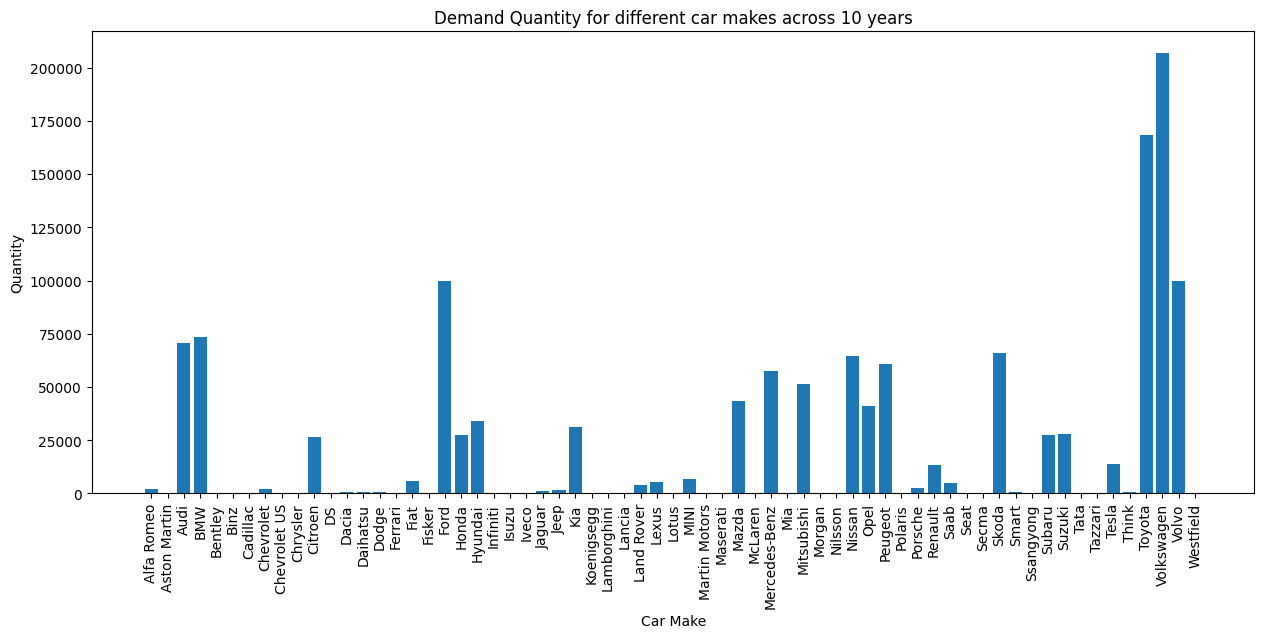

In [37]:
# Simple visualization

make_df = data.groupby(['Make'])['Quantity'].sum()

plt.figure(figsize=(15, 6))
plt.bar(make_df.index, make_df)
plt.title('Demand Quantity for different car makes across 10 years')
plt.xlabel('Car Make')
plt.ylabel('Quantity')
plt.xticks(rotation=90)
plt.show()

In [38]:
# Transforming data into time series. Each car make will have a row and the columns will be the time period

df = pd.pivot_table(
    data=data,
    index='Make',
    columns='Period',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [39]:
print(f"Number of unique car makes = {df.shape[0]}")
print(f"Number of total time periods = {df.shape[1]}")

Number of unique car makes = 65
Number of total time periods = 121


In [40]:
# Prepare data - Create X_train, Y_train, X_test and Y_test

def prepare_data(df, window_length=12):

    values = df.values
    rows, periods = df.shape

    loops = periods - window_length

    X = []
    Y = []
    for i in range(loops):
        X.append(values[:, i : i + window_length])
        Y.append(values[:, i + window_length])

    X_train = np.vstack(X)
    Y_train = np.ravel(np.array(Y))

    # Splitting train and test data
    X_train, X_test = np.split(X_train, [-window_length * rows], axis=0)
    Y_train, Y_test = np.split(Y_train, [-window_length * rows], axis=0)

    return X_train, Y_train, X_test, Y_test

In [41]:
X_train, Y_train, X_test, Y_test = prepare_data(df, window_length=12)
print(f'X_train shape = {X_train.shape}')
print(f'Y_train shape = {Y_train.shape}')
print(f'X_test shape = {X_test.shape}')
print(f'Y_test shape = {Y_test.shape}')

X_train shape = (6305, 12)
Y_train shape = (6305,)
X_test shape = (780, 12)
Y_test shape = (780,)


In [42]:
from sklearn.metrics import mean_absolute_error, \
                            mean_squared_error, \
                            root_mean_squared_error, \
                            r2_score

def ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):

    # Initialize dataframe to store the results
    df = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R2 Score', 'Bias'], index=['Train', 'Test'])
    df.index.name = name

    # Calculate metrics for the train set
    df.loc['Train', 'MAE'] = mean_absolute_error(Y_train, Y_train_pred)
    df.loc['Train', 'MSE'] = mean_squared_error(Y_train, Y_train_pred)
    df.loc['Train', 'RMSE'] = root_mean_squared_error(Y_train, Y_train_pred)
    df.loc['Train', 'R2 Score'] = r2_score(Y_train, Y_train_pred)
    df.loc['Train', 'Bias'] = np.mean((Y_train - Y_train_pred))

    # Calculate metrics for the test set
    df.loc['Test', 'MAE'] = mean_absolute_error(Y_test, Y_test_pred)
    df.loc['Test', 'MSE'] = mean_squared_error(Y_test, Y_test_pred)
    df.loc['Test', 'RMSE'] = root_mean_squared_error(Y_test, Y_test_pred)
    df.loc['Test', 'R2 Score'] = r2_score(Y_test, Y_test_pred)
    df.loc['Test', 'Bias'] = np.mean((Y_test - Y_test_pred))

    # Format the dataframe for better presentation
    df = df.astype(float).round(3)

    # Print the results
    print(df)

    return df

## 2. Linear Regression - Ordinary Least Squares

In [95]:
from sklearn.linear_model import LinearRegression

# Model fitting
reg = LinearRegression()
reg.fit(X_train, Y_train)

# Prediction using trained model
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

# Calculating KPIs
linear_reg_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Linear Regression')


print('')
print("----Optimized parameters----")
print(reg.coef_)

                      MAE       MSE    RMSE  R2 Score   Bias
Linear Regression                                           
Train              30.047  5462.607  73.909     0.951  0.000
Test               35.786  7697.288  87.734     0.952  3.311

----Optimized parameters----
[ 0.33089965 -0.02473291 -0.11218999 -0.07593725 -0.03279009 -0.00193742
  0.13859641  0.0593907   0.03971699  0.19517259  0.19189094  0.29097306]


In [ ]:
import seaborn as sns
import scipy.stats as stats

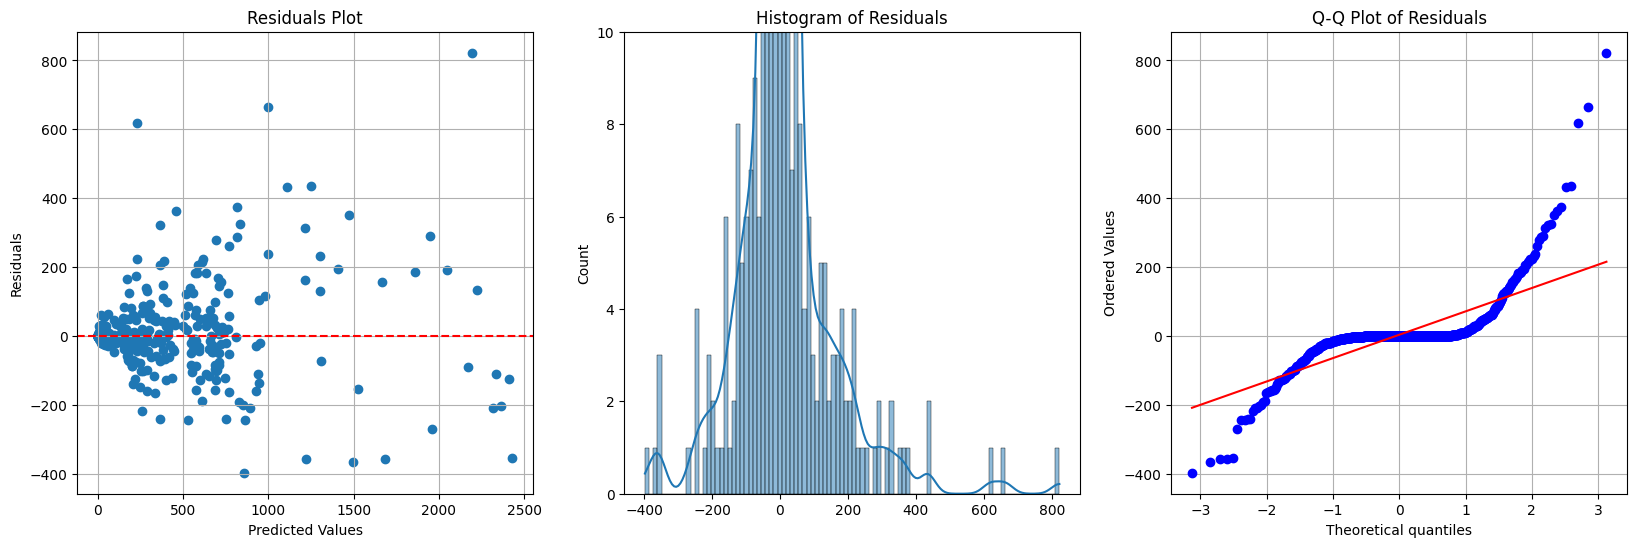

In [96]:
# Visualizing the residuals, QQ plots

residuals = Y_test - Y_test_pred

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Residuals against predicted values
ax[0].scatter(Y_test_pred.flatten(), residuals.flatten())
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Residuals Plot")
ax[0].grid(True)


# Histogram of residuals
sns.histplot(residuals, bins=100, kde=True, ax=ax[1])
ax[1].set_title("Histogram of Residuals")
ax[1].set_ylim(top=10)


# QQ Plot of residuals
stats.probplot(residuals, dist="norm", plot=ax[2])
ax[2].set_title("Q-Q Plot of Residuals")
ax[2].grid(True)

plt.show()

In [97]:
print(np.mean(Y_test))

200.8551282051282


In [101]:
# Cross validation

window_length = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

best_model = None
best_score = float('inf')

for n in window_length:
    X_train, Y_train, X_test, Y_test = prepare_data(df, window_length=n)

    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    score = mean_absolute_error(Y_train, Y_train_pred)

    if score < best_score:
        best_score = score
        best_model = model  # Save the best model
        opti_window_length = n

print("Best MAE:", best_score)

Best MAE: 30.0468681299026


In [102]:
print(f'Optimium window_length = {opti_window_length}\n')
print(f'Coefficients for the best model:\n')
print(best_model.coef_)

Optimium window_length = 12

Coefficients for the best model:

[ 0.33089965 -0.02473291 -0.11218999 -0.07593725 -0.03279009 -0.00193742
  0.13859641  0.0593907   0.03971699  0.19517259  0.19189094  0.29097306]


In [100]:
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

linear_reg_opti_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Linear Regression Optimized')

                                MAE       MSE    RMSE  R2 Score   Bias
Linear Regression Optimized                                           
Train                        30.047  5462.607  73.909     0.951  0.000
Test                         35.786  7697.288  87.734     0.952  3.311


#### Observations

- Residuals fall in the (-400, 400) range, only few outliers. Looking at the R2 Score, 95% of the variance is explained by the features.
- The Q-Q plot shows heavier tails, the residuals are not exactly distributed normally. The deviation is highest at the extremes.
- MAE for test set = 35.786, the average demand observed in the test set = 200.856
- The percentage error is approximately 17%, whether this is acceptable has to be determined based on the financial ramifications of holding extra inventory, lead times, opportunity cost of lost sales, etc.
- On exploring the results across the window length, window length of 12 is found to be the best predictor.

## 3. Decision Trees

In [104]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, min_samples_split=15, min_samples_leaf=5)
tree.fit(X_train, Y_train)

# Forecast and return forecasting accuracy KPIs
Y_train_pred = tree.predict(X_train)
Y_test_pred = tree.predict(X_test)

decision_tree_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

          MAE        MSE     RMSE  R2 Score   Bias
Tree                                              
Train  30.421   5338.813   73.067     0.952 -0.000
Test   42.332  11170.957  105.693     0.930  6.443


In [105]:
import time

# Dictionary to store results
results = []

# Loop through different criteria
for criterion in ['squared_error', 'absolute_error']:
    start_time = time.time()

    # Initialize and fit the model
    tree = DecisionTreeRegressor(
        max_depth=5, min_samples_split=15, min_samples_leaf=5, criterion=criterion
    )
    tree.fit(X_train, Y_train)

    # Predict and evaluate KPIs
    Y_train_pred = tree.predict(X_train)
    Y_test_pred = tree.predict(X_test)
    ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name=f'Tree {criterion}')
    print()

    # Record training time
    training_time = time.time() - start_time
    results.append([criterion, training_time])

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results, columns=['Criterion', 'Training Time (seconds)'])
print(results_df)

                       MAE        MSE     RMSE  R2 Score   Bias
Tree squared_error                                             
Train               30.421   5338.813   73.067     0.952 -0.000
Test                42.332  11170.957  105.693     0.930  6.443

                        MAE        MSE     RMSE  R2 Score    Bias
Tree absolute_error                                              
Train                30.150   6268.332   79.173     0.944   3.803
Test                 43.142  13807.248  117.504     0.913  10.510

        Criterion  Training Time (seconds)
0   squared_error                 0.113401
1  absolute_error                 1.372861


In [106]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter grid
max_depth = list(range(5, 11)) + [None]
min_samples_split = range(5, 20)
min_samples_leaf = range(2, 20)
param_dist = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

# Setup model
tree = DecisionTreeRegressor()

# Apply K-Fold Cross-Validation & Random Search with MAE scoring
tree_cv = RandomizedSearchCV(
    estimator=tree, param_distributions=param_dist, n_iter=100,
    scoring='neg_mean_absolute_error', n_jobs=-1, cv=10, verbose=1
)
tree_cv.fit(X_train, Y_train)

# Output the best parameters and score
print('Tuned Regression Tree Parameters:', tree_cv.best_params_)
print('Best Cross-Validation MAE:', -tree_cv.best_score_)  # Negate to get positive MAE

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned Regression Tree Parameters: {'min_samples_split': 7, 'min_samples_leaf': 18, 'max_depth': 7}
Best Cross-Validation MAE: 33.993264432152635


In [107]:
# Use the tuned model with optimized parameters to forecast and return forecasting accuracy KPIs
y_train_pred = tree_cv.predict(X_train)
y_test_pred = tree_cv.predict(X_test)

tuned_tree_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

          MAE        MSE     RMSE  R2 Score    Bias
Tree                                               
Train  30.150   6268.332   79.173     0.944   3.803
Test   43.142  13807.248  117.504     0.913  10.510


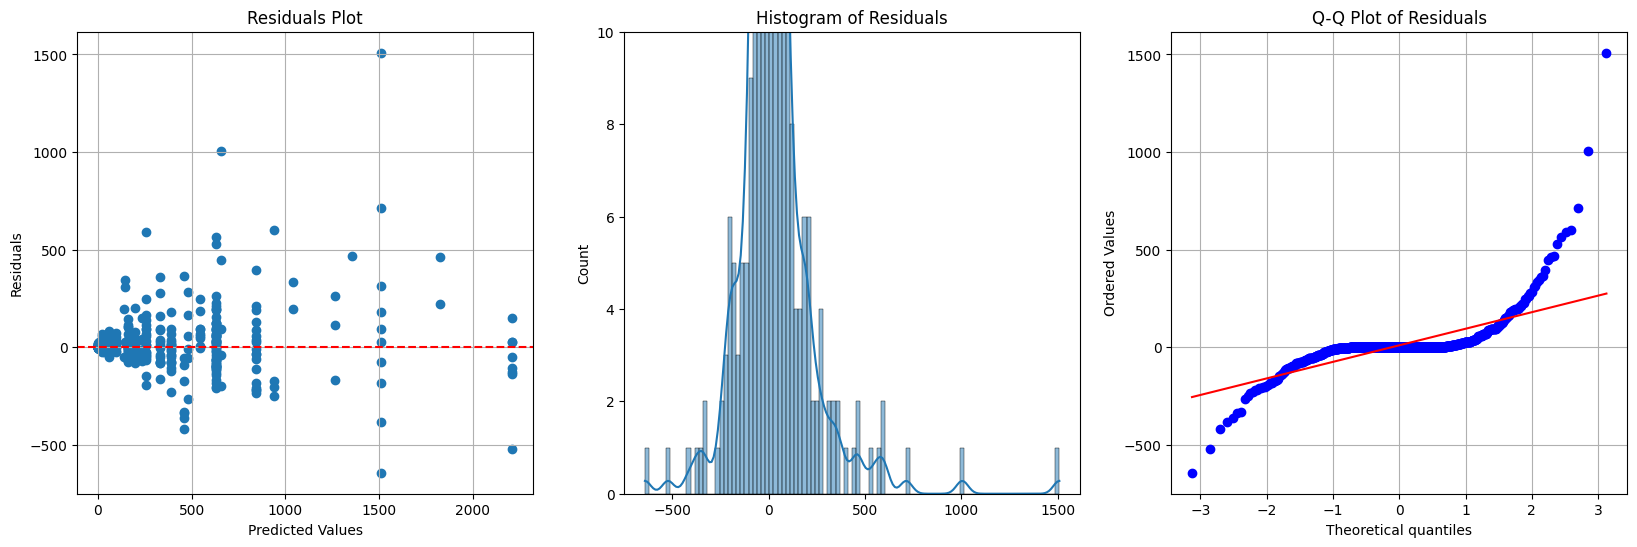

In [108]:
# Visualizing the residuals, QQ plots

residuals = Y_test - Y_test_pred

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Residuals against predicted values
ax[0].scatter(Y_test_pred.flatten(), residuals.flatten())
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Residuals Plot")
ax[0].grid(True)


# Histogram of residuals
sns.histplot(residuals, bins=100, kde=True, ax=ax[1])
ax[1].set_title("Histogram of Residuals")
ax[1].set_ylim(top=10)


# QQ Plot of residuals
stats.probplot(residuals, dist="norm", plot=ax[2])
ax[2].set_title("Q-Q Plot of Residuals")
ax[2].grid(True)

plt.show()

#### Observations

- The optimized Decision Tree Regressor performs worse than the Linear Regressor as the MAE on the test set is greater.

## 4. Random Forests

In [118]:
from sklearn.ensemble import RandomForestRegressor

# Setup model and fit train set
forest = RandomForestRegressor(
    bootstrap=True,
    max_samples=0.95,
    max_features=11,
    min_samples_leaf=18,
    max_depth=7
)
forest.fit(X_train, Y_train)

# Forecast and return forecasting accuracy KPIs
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

random_foreset_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest')

           MAE       MSE    RMSE  R2 Score   Bias
Forest                                           
Train   26.431  4554.333  67.486     0.959  0.214
Test    36.950  9053.457  95.150     0.943  8.044


In [119]:
# Parameter optimization with RandomizedSearchCV, n_estimators = 30

# Parameter grid
max_depth = list(range(5, 11)) + [None]
min_samples_split = range(5, 20)
min_samples_leaf = range(2, 15)
max_features = range(3, 8)
bootstrap = [True]
max_samples = [.7, .8, .9, .95, 1]

param_dist = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'max_samples': max_samples
}

# Apply K-Fold Cross-Validation & Random Search with MAE scoring to the model
forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    cv=6,
    n_jobs=-1,
    verbose=2,
    n_iter=400,
    scoring='neg_mean_absolute_error'
)

forest_cv.fit(X_train, Y_train)
print('Tuned Forest Parameters:', forest_cv.best_params_)

# Use the tuned model with optimized parameters to forecast and return forecasting accuracy KPIs
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)

optimized_random_forest_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Tuned Forest Parameters: {'min_samples_split': 16, 'min_samples_leaf': 8, 'max_samples': 0.9, 'max_features': 4, 'max_depth': 10, 'bootstrap': True}
                     MAE       MSE    RMSE  R2 Score   Bias
Forest optimized                                           
Train             23.964  3769.925  61.400     0.966  0.098
Test              36.233  8528.327  92.349     0.947  6.609


In [120]:
# Parameter optimization with RandomizedSearchCV, n_estimators = 200

forest = RandomForestRegressor(n_estimators=200, n_jobs=-1, **forest_cv.best_params_)
forest = forest.fit(X_train, Y_train)
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
random_forest_200_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest n_estimators = 200')

                              MAE       MSE    RMSE  R2 Score   Bias
Forest n_estimators = 200                                           
Train                      23.875  3750.695  61.243     0.967  0.034
Test                       35.714  8421.472  91.769     0.947  5.832


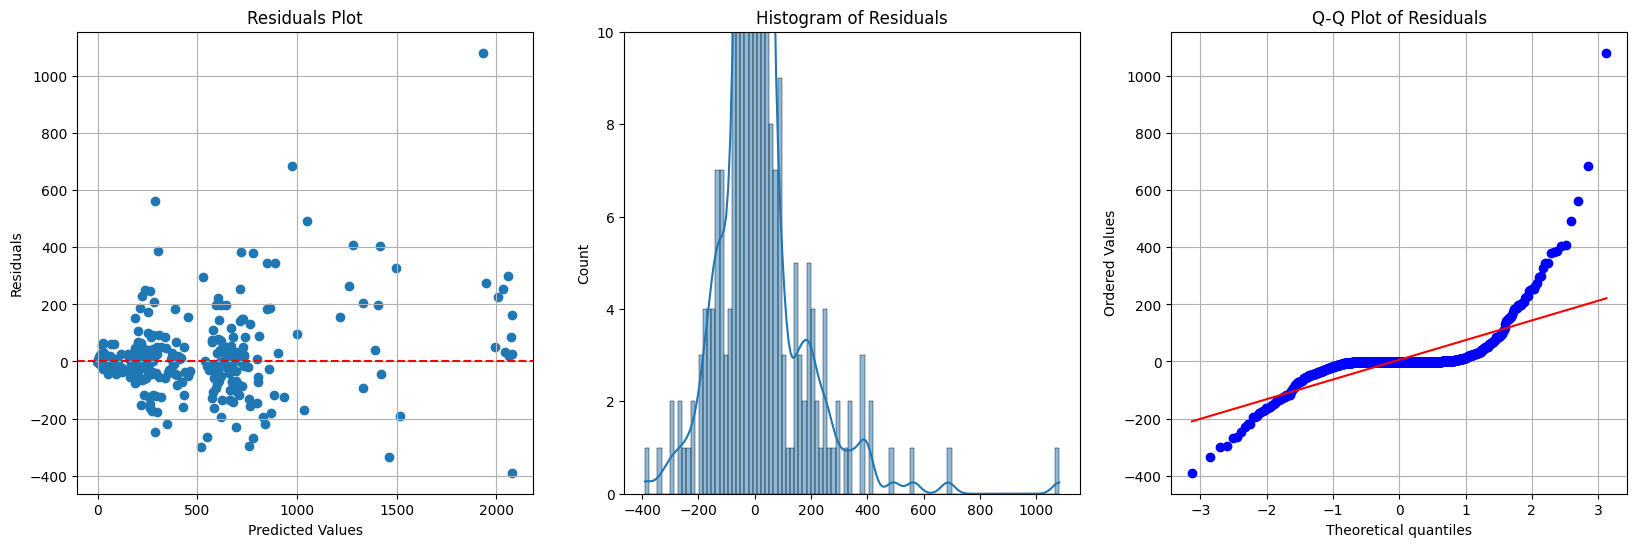

In [122]:
# Visualizing the residuals, QQ plots

residuals = Y_test - Y_test_pred

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Residuals against predicted values
ax[0].scatter(Y_test_pred.flatten(), residuals.flatten())
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Residuals Plot")
ax[0].grid(True)


# Histogram of residuals
sns.histplot(residuals, bins=100, kde=True, ax=ax[1])
ax[1].set_title("Histogram of Residuals")
ax[1].set_ylim(top=10)


# QQ Plot of residuals
stats.probplot(residuals, dist="norm", plot=ax[2])
ax[2].set_title("Q-Q Plot of Residuals")
ax[2].grid(True)

plt.show()

## 4.1 Feature Optimization - What is the best window length?

Having found the best hyper-parameters for the RandomForest, we will try to find the best window length.

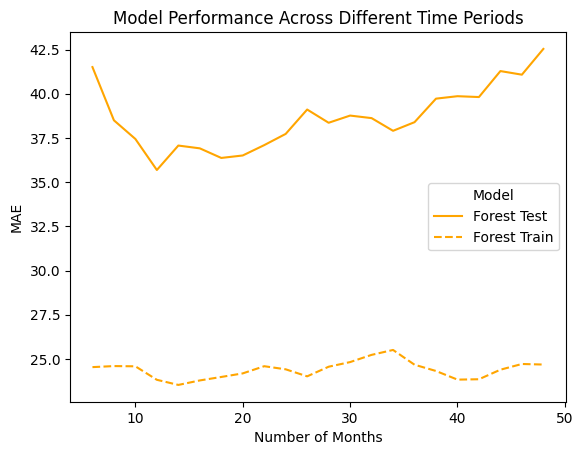

Model
Forest Test     12
Forest Train    14
dtype: int64


In [125]:
'''Tuned Forest Parameters: {'min_samples_split': 16, 'min_samples_leaf': 8, 'max_samples': 0.9, 'max_features': 4, 'max_depth': 10, 'bootstrap': True}'''

forest_features = {
    "n_jobs": -1,
    "n_estimators": 200,
    "min_samples_split": 16,
    "min_samples_leaf": 8,
    "max_samples": 0.9,
    "max_features": 4,
    "max_depth": 10,
    "bootstrap": True
}
forest = RandomForestRegressor(**forest_features)

# We want to optimize for MAE

def model_mae(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    return mae

# Define range for months (from 6 to 50 with a 2-month gap)
n_months = range(6, 50, 2)

# Empty list to store the results
results = []

# Train and test models to find the optimal number of features
for x_len in n_months:
    X_train, Y_train, X_test, Y_test = prepare_data(df, window_length=x_len)

    forest.fit(X_train, Y_train)
    mae_train = model_mae(forest, X_train, Y_train)
    mae_test = model_mae(forest, X_test, Y_test)

    results.append([f"Forest Train", mae_train, x_len])
    results.append([f"Forest Test", mae_test, x_len])

# Format results into a DataFrame for visualization
data = pd.DataFrame(results, columns=["Model", "MAE", "Number of Months"])
data = data.set_index(["Number of Months", "Model"]).stack().unstack("Model")
data.index = data.index.droplevel(level=1)
data.index.name = "Number of Months"

# Visualize the results
data.plot(color=["orange"] * 2 + ["black"] * 2, style=["-", "--"] * 2)
plt.xlabel("Number of Months")
plt.ylabel("MAE")
plt.title("Model Performance Across Different Time Periods")
plt.show()

# Print the optimal number of features
print(data.idxmin())

In [127]:
forest_features = {
    "n_jobs": -1,
    "n_estimators": 200,
    "min_samples_split": 16,
    "min_samples_leaf": 8,
    "max_samples": 0.9,
    "max_features": 4,
    "max_depth": 10,
    "bootstrap": True
}
forest = RandomForestRegressor(**forest_features)

X_train, Y_train, X_test, Y_test = prepare_data(df, window_length=12)

forest.fit(X_train, Y_train)

Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

opti_random_forest_result = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Opti Random Forest')

                       MAE       MSE    RMSE  R2 Score   Bias
Opti Random Forest                                           
Train               23.812  3743.816  61.187     0.967 -0.002
Test                35.556  8378.523  91.534     0.947  5.709


#### Observations

- Random forest after tuning gives similar MAE as compared to the Linear Regressor

In [144]:
makes = ['Audi', 'BMW', 'Ford', 'Volvo', 'Mercedes-Benz', 'Nissan', 'Skoda']

filtered_df = df[df.index.isin(makes)]
filtered_df.shape

(7, 121)

In [145]:
forest_features = {
    "n_jobs": -1,
    "n_estimators": 200,
    "min_samples_split": 16,
    "min_samples_leaf": 8,
    "max_samples": 0.9,
    "max_features": 4,
    "max_depth": 10,
    "bootstrap": True
}
forest = RandomForestRegressor(**forest_features)

X_train, Y_train, X_test, Y_test = prepare_data(filtered_df, window_length=12)

forest.fit(X_train, Y_train)

Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

filtered_random_forest_result = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Opti Random Forest')

                        MAE        MSE     RMSE  R2 Score    Bias
Opti Random Forest                                               
Train                79.309  12730.265  112.828     0.782   0.325
Test                116.532  28059.259  167.509     0.366  27.352


In [146]:
# Parameter optimization with RandomizedSearchCV, n_estimators = 30

# Parameter grid
max_depth = list(range(5, 11)) + [None]
min_samples_split = range(5, 20)
min_samples_leaf = range(2, 15)
max_features = range(3, 8)
bootstrap = [True]
max_samples = [.7, .8, .9, .95, 1]

param_dist = {
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features,
    'bootstrap': bootstrap,
    'max_samples': max_samples
}

# Apply K-Fold Cross-Validation & Random Search with MAE scoring to the model
forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    cv=6,
    n_jobs=-1,
    verbose=2,
    n_iter=400,
    scoring='neg_mean_absolute_error'
)

forest_cv.fit(X_train, Y_train)
print('Tuned Forest Parameters:', forest_cv.best_params_)

# Use the tuned model with optimized parameters to forecast and return forecasting accuracy KPIs
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)

filtered_optimized_random_forest_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Tuned Forest Parameters: {'min_samples_split': 12, 'min_samples_leaf': 2, 'max_samples': 0.7, 'max_features': 5, 'max_depth': 10, 'bootstrap': True}
                      MAE        MSE     RMSE  R2 Score    Bias
Forest optimized                                               
Train              70.604  10072.586  100.362     0.827  -0.446
Test              115.925  27430.687  165.622     0.380  20.542


In [147]:
forest = RandomForestRegressor(n_estimators=200, **forest_cv.best_params_, n_jobs=-1)

forest.fit(X_train, Y_train)

Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Opti Random Forest')

                        MAE        MSE     RMSE  R2 Score    Bias
Opti Random Forest                                               
Train                69.979   9716.796   98.574     0.833  -0.453
Test                116.037  27421.845  165.595     0.380  27.864


,MAE,MSE,RMSE,R2 Score,Bias
Opti Random Forest,,,,,
Train,69.979,9716.796,98.574,0.833,-0.453
Test,116.037,27421.845,165.595,0.380,27.864


In [148]:
np.mean(Y_test)

np.float64(749.5595238095239)

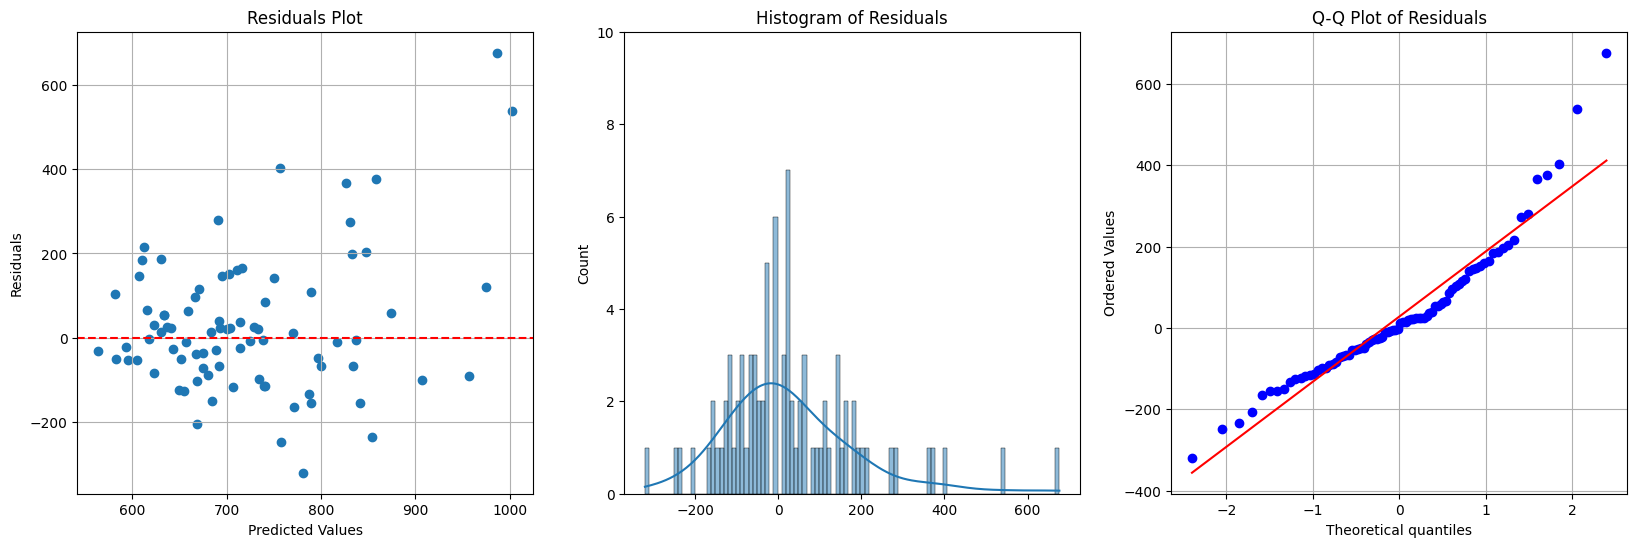

In [152]:
# Visualizing the residuals, QQ plots

residuals = Y_test - Y_test_pred

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Residuals against predicted values
ax[0].scatter(Y_test_pred.flatten(), residuals.flatten())
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Residuals Plot")
ax[0].grid(True)


# Histogram of residuals
sns.histplot(residuals, bins=100, kde=True, ax=ax[1])
ax[1].set_title("Histogram of Residuals")
ax[1].set_ylim(top=10)


# QQ Plot of residuals
stats.probplot(residuals, dist="norm", plot=ax[2])
ax[2].set_title("Q-Q Plot of Residuals")
ax[2].grid(True)

plt.show()

## 5. Extreme Gradient Boosting / XGBoost

In [155]:
from xgboost.sklearn import XGBRegressor

XGB = XGBRegressor(
    n_jobs=-1,
    max_depth=10,
    n_estimators=100,
    learning_rate=0.2
)

X_train, Y_train, X_test, Y_test = prepare_data(df, window_length=12)

XGB = XGB.fit(X_train, Y_train)

Y_train_pred = XGB.predict(X_train)
Y_test_pred = XGB.predict(X_test)

XGB_results = ML_forecast_KPIs(Y_train, Y_train_pred, Y_test, Y_test_pred, name='XGB Regressor')

                  MAE       MSE    RMSE  R2 Score   Bias
XGB Regressor                                           
Train           1.280     6.963   2.639     1.000  0.005
Test           37.711  9080.030  95.289     0.943  4.953


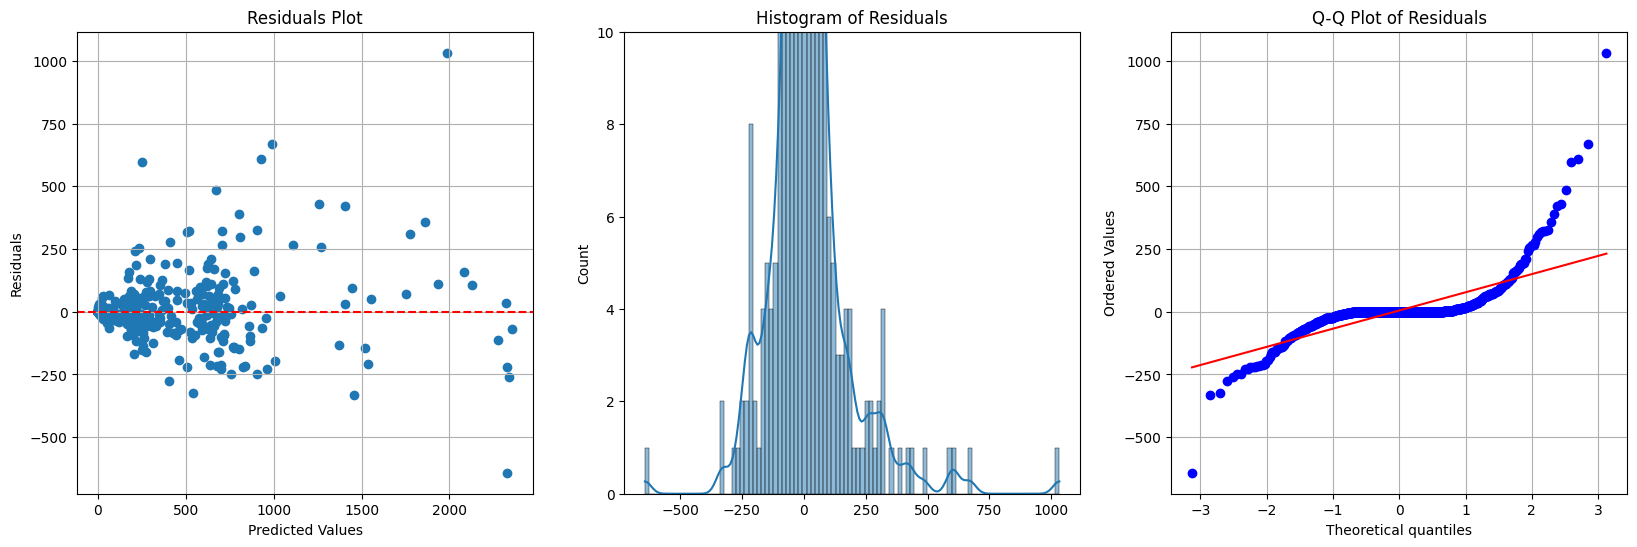

In [156]:
# Visualizing the residuals, QQ plots

residuals = Y_test - Y_test_pred

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Residuals against predicted values
ax[0].scatter(Y_test_pred.flatten(), residuals.flatten())
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_xlabel("Predicted Values")
ax[0].set_ylabel("Residuals")
ax[0].set_title("Residuals Plot")
ax[0].grid(True)


# Histogram of residuals
sns.histplot(residuals, bins=100, kde=True, ax=ax[1])
ax[1].set_title("Histogram of Residuals")
ax[1].set_ylim(top=10)


# QQ Plot of residuals
stats.probplot(residuals, dist="norm", plot=ax[2])
ax[2].set_title("Q-Q Plot of Residuals")
ax[2].grid(True)

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

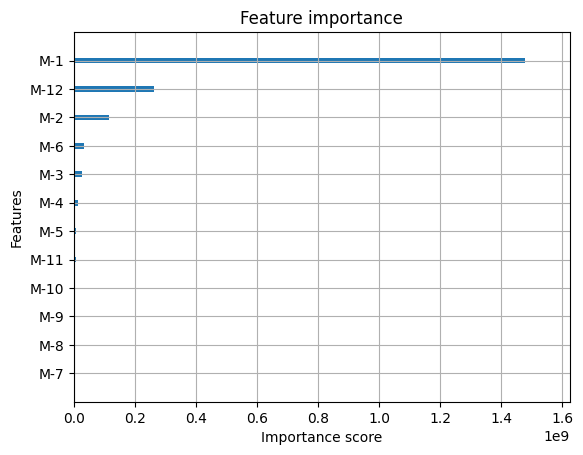

In [157]:
import xgboost as xgb

XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)

In [69]:
def datasets_holdout(df, x_len=12, y_len=1, test_loops=12, holdout_loops=0):
    data_values = df.values
    rows, periods = data_values.shape

    # Training set creation
    train_loops = periods + 1 - x_len - y_len
    train = [data_values[:, col : col + x_len + y_len] for col in range(train_loops)]
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)

    # Holdout set creation
    if holdout_loops > 0:
        X_train, X_holdout = np.split(X_train, [-rows * holdout_loops], axis=0)
        Y_train, Y_holdout = np.split(Y_train, [-rows * holdout_loops], axis=0)
    else:
        X_holdout, Y_holdout = np.array([]), np.array([])

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows * test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows * test_loops], axis=0)
    else:  # No test set: X_test is used to generate the future forecast
        X_test = data_values[:, -x_len:]
        y_test = np.full((X_test.shape[0], y_len), np.nan)  # Dummy value

    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        Y_holdout = Y_holdout.ravel()

    return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test